In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.functional as F
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error
%matplotlib inline

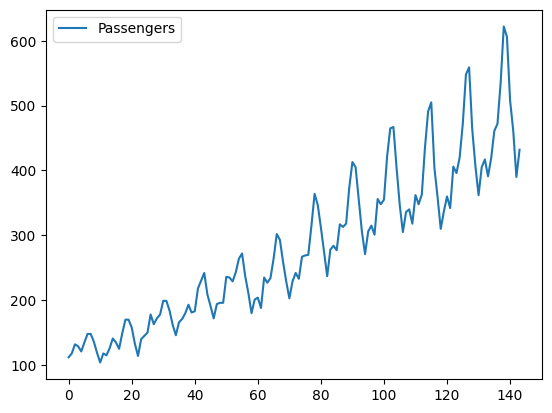

In [38]:
#Loading the dataframe
df = pd.read_csv("airline-passengers.csv", usecols = [1])
df.plot()
plt.show()

In [39]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 1.3 KB


In [40]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [41]:
#Data Preprocessing
dataset = df.values
dataset = dataset.astype('float32')
dataset.reshape(-1,1)
#MinMax Scaling
Minmax = MinMaxScaler()

scaled_dataset = Minmax.fit_transform(dataset)

In [42]:
#Splitting the data
train_size = int(0.67 * len(scaled_dataset))
test_size = len(scaled_dataset) - train_size
train_data, test_data = scaled_dataset[0:train_size, :], scaled_dataset[train_size:len(scaled_dataset)]
print(len(train_data), len(test_data.shape))
train_data

96 2


array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984557],
       [0.08494207],
       [0.08494207],
       [0.06177607],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123553],
       [0.04247104],
       [0.07142857],
       [0.05984557],
       [0.04054055],
       [0.08687258],
       [0.12741312],
       [0.12741312],
       [0.10424709],
       [0.05598456],
       [0.01930502],
       [0.06949806],
       [0.07915059],
       [0.08880308],
       [0.14285713],
       [0.11389962],
       [0.13127413],
       [0.14285713],
       [0.18339768],
       [0.18339768],
       [0.15444016],
       [0.11196911],
       [0.08108109],
       [0.1196911 ],
       [0.12934363],
       [0.14671814],
       [0.17181468],
       [0.14864865],
       [0.15250966],
       [0.22007722],
       [0.24324325],
       [0.26640925],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

In [43]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back- 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


In [44]:
look_back = 1
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

In [45]:
#Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [46]:
#Convert the trainX and testX numpy arrays into tensor
trainX = torch.tensor(trainX, dtype = torch.float32)
trainY = torch.tensor(trainY, dtype = torch.float32)
testX = torch.tensor(testX, dtype = torch.float32)
testY  = torch.tensor(testY, dtype = torch.float32)
print(trainX.shape)
print(testY.shape)


torch.Size([94, 1, 1])
torch.Size([46])


In [47]:
#Create dataset
train_dataset = TensorDataset(trainX, trainY)
test_dataset = TensorDataset(testX, testY)
#Create Dataloader
train_loader = DataLoader(train_dataset, batch_size = 1, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle = False)

In [48]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        
        #LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True)

        #Fully Connected Layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
            #Initialize hidden state and cell state 
            _, (hn, _) = self.lstm(x)  # hn is the hidden state
            out = self.fc(hn[-1])     # Fully connected layer
            return out
        
# Model parameters
input_size = 1
hidden_size = 4
output_size = 1
model = LSTMModel(input_size, hidden_size, output_size)

In [49]:
#Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [50]:
#Training the model 
num_epochs = 100
for epoch in range(num_epochs):
    for batch_X, batch_Y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.0252
Epoch [20/100], Loss: 0.0021
Epoch [30/100], Loss: 0.0006
Epoch [40/100], Loss: 0.0048
Epoch [50/100], Loss: 0.0007
Epoch [60/100], Loss: 0.0052
Epoch [70/100], Loss: 0.0006
Epoch [80/100], Loss: 0.0008
Epoch [90/100], Loss: 0.0038
Epoch [100/100], Loss: 0.0001


In [51]:
model.eval()
with torch.no_grad():
    trainPredict = model(trainX).squeeze()
    testPredict = model(testX).squeeze()

# Invert predictions and original data
trainPredict = Minmax.inverse_transform(trainPredict.reshape(-1, 1))
trainY = Minmax.inverse_transform(trainY.reshape(-1, 1))
testPredict = Minmax.inverse_transform(testPredict.reshape(-1, 1))
testY = Minmax.inverse_transform(testY.reshape(-1, 1))

# Calculate RMSE
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print(f'Train Score: {trainScore:.2f} RMSE')
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print(f'Test Score: {testScore:.2f} RMSE')


Train Score: 24.75 RMSE
Test Score: 54.35 RMSE


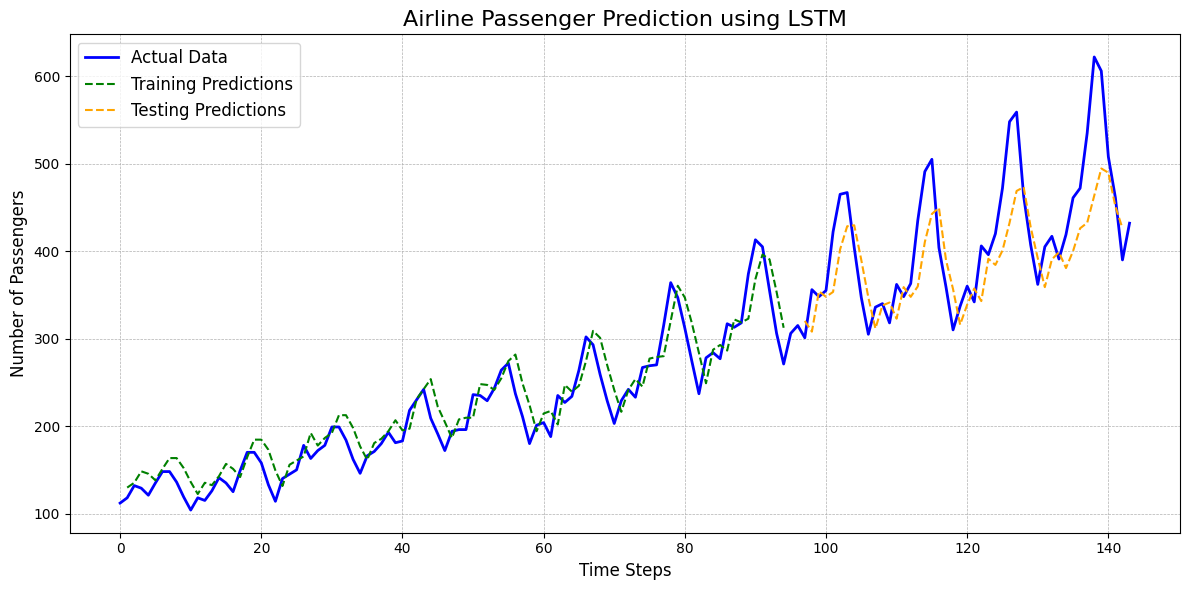

In [52]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(scaled_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled_dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(12,6))
plt.plot(Minmax.inverse_transform(scaled_dataset), label='Actual Data', color='blue', linewidth=2)
plt.plot(trainPredictPlot, label='Training Predictions', color='green', linestyle='dashed', linewidth=1.5)
plt.plot(testPredictPlot, label='Testing Predictions', color='orange', linestyle='dashed', linewidth=1.5)
plt.title('Airline Passenger Prediction using LSTM', fontsize=16)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)

# Add a legend to differentiate the lines
plt.legend(fontsize=12)

# Customize grid for better readability
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
